In [19]:
import tensorflow
import tensorflow.keras
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

%matplotlib inline

In [11]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (2916, 150, 150, 3) 	Validation dataset shape: (2844, 150, 150, 3)


In [12]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [13]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['cat', 'cat', 'dog', 'dog', 'dog'] [0 0 1 1 1]


In [18]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [21]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x63ceaa350>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63aeb1a50>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63ceaae90>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x63ceaab50>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63ceaca10>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63ce85d10>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x63ce85ed0>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63cee7ed0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63cef8f10>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63cf0cd50>,block3_conv3,False


In [22]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


(1, 4, 4, 512)


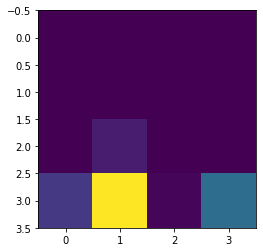

In [23]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [24]:
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [25]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (2916, 8192) 	Validation Bottleneck Features: (2844, 8192)


In [27]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 2916 samples, validate on 2844 samples
Epoch 1/30
2916/2916 [==============================] - 16s 5ms/sample - loss: 0.4540 - accuracy: 0.7774 - val_loss: 0.2805 - val_accuracy: 0.8769
Epoch 2/30
2916/2916 [==============================] - 9s 3ms/sample - loss: 0.2897 - accuracy: 0.8800 - val_loss: 0.2412 - val_accuracy: 0.8942
Epoch 3/30
2916/2916 [==============================] - 9s 3ms/sample - loss: 0.2333 - accuracy: 0.9036 - val_loss: 0.2904 - val_accuracy: 0.8836
Epoch 4/30
2916/2916 [==============================] - 9s 3ms/sample - loss: 0.1975 - accuracy: 0.9187 - val_loss: 0.2626 - val_accuracy: 0.8910
Epoch 5/30
2916/2916 [==============================] - 10s 3ms/sample - loss: 0.1638 - accuracy: 0.9359 - val_loss: 0.2511 - val_accuracy: 0.8938
Epoch 6/30
2916/2916 [==============================] - 10s 4ms/sample - loss: 0.1507 - accuracy: 0.9403 - val_loss: 0.2420 - val_accuracy: 0.9072
Epoch 7/30
2916/2916 [==============================] - 11s 4ms/sample - 

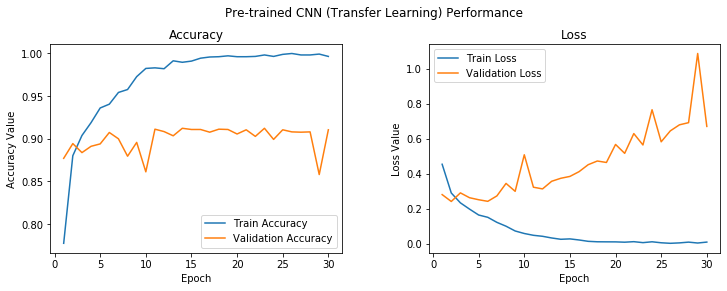

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [31]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

In [32]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [35]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8192)              14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
__________________________________

In [38]:
history = model.fit_generator(train_generator, steps_per_epoch=50, epochs=30,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/30
50/50 [==============================] - 1151s 23s/step - loss: 0.4009 - accuracy: 0.8117 - val_loss: 0.2682 - val_accuracy: 0.8830
Epoch 2/30
50/50 [==============================] - 1105s 22s/step - loss: 0.4156 - accuracy: 0.8047 - val_loss: 0.2649 - val_accuracy: 0.8830
Epoch 3/30
50/50 [==============================] - 1102s 22s/step - loss: 0.4129 - accuracy: 0.8062 - val_loss: 0.2627 - val_accuracy: 0.8850
Epoch 4/30
50/50 [==============================] - 1150s 23s/step - loss: 0.4071 - accuracy: 0.8067 - val_loss: 0.2891 - val_accuracy: 0.8800
Epoch 5/30
50/50 [==============================] - 1097s 22s/step - loss: 0.4029 - accuracy: 0.8150 - val_loss: 0.2608 - val_accuracy: 0.8850
Epoch 6/30
50/50 [==============================] - 1048s 21s/step - loss: 0.4092 - accuracy: 0.7927 - val_loss: 0.2562 - val_accuracy: 0.8810
Epoch 7/30
50/50 [==============================] - 1048s 21s/step - loss: 0.4182 - accuracy: 0.8073 - val_loss: 0.2586 - val_accuracy: 0.8910

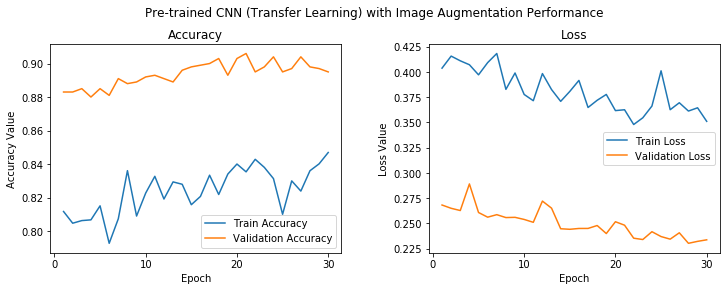

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [42]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

In [43]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: [<tf.Variable 'block4_conv1_1/kernel:0' shape=(3, 3, 256, 512) dtype=float32, numpy=
array([[[[-1.24538150e-02,  8.40655994e-03, -5.28845051e-03, ...,
          -2.04581907e-03, -3.92359449e-03,  1.30683812e-03],
         [ 1.15566896e-02,  2.46055960e-03, -4.09082584e-02, ...,
          -4.92062652e-03, -1.63423386e-03,  8.94230697e-03],
         [-1.43469922e-04, -5.65873180e-03,  1.84066985e-02, ...,
          -2.08840682e-03,  2.63321817e-06, -2.50728261e-02],
         ...,
         [ 1.37888230e-02, -6.58180192e-03,  9.65370331e-03, ...,
           7.17610447e-03,  3.45725450e-03,  5.33173978e-03],
         [ 2.65833316e-03,  7.77704641e-04,  2.86239345e-04, ...,
          -5.40583069e-03,  8.93119723e-03,  1.40043022e-02],
         [-8.53933115e-03,  1.43394794e-03, -2.91879033e-03, ...,
           3.77660524e-03,  2.05454584e-02, -1.35868033e-02]],

        [[-1.20176468e-02,  1.51250837e-03,  3.43130133e-03, ...,
          -1.57830697e-02, -2.39501009e-03,  2.

In [44]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x63ceaa350>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63aeb1a50>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63ceaae90>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x63ceaab50>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63ceaca10>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63ce85d10>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x63ce85ed0>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63cee7ed0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63cef8f10>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x63cf0cd50>,block3_conv3,False


In [45]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [48]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8192)              14714688  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
__________________________________

In [49]:
history = model.fit_generator(train_generator, steps_per_epoch=50, epochs=30,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/30
50/50 [==============================] - 1331s 27s/step - loss: 0.7153 - accuracy: 0.5217 - val_loss: 0.6322 - val_accuracy: 0.6700
Epoch 2/30
50/50 [==============================] - 1432s 29s/step - loss: 0.6692 - accuracy: 0.6000 - val_loss: 0.5911 - val_accuracy: 0.6730
Epoch 3/30
50/50 [==============================] - 1416s 28s/step - loss: 0.6360 - accuracy: 0.6389 - val_loss: 0.5401 - val_accuracy: 0.7650
Epoch 4/30
50/50 [==============================] - 1275s 26s/step - loss: 0.6192 - accuracy: 0.6567 - val_loss: 0.5049 - val_accuracy: 0.7820
Epoch 5/30
50/50 [==============================] - 1304s 26s/step - loss: 0.5974 - accuracy: 0.6773 - val_loss: 0.4720 - val_accuracy: 0.8160
Epoch 6/30
50/50 [==============================] - 1188s 24s/step - loss: 0.5864 - accuracy: 0.6924 - val_loss: 0.4498 - val_accuracy: 0.8190
Epoch 7/30
50/50 [==============================] - 1060s 21s/step - loss: 0.5633 - accuracy: 0.7073 - val_loss: 0.4290 - val_accuracy: 0.8180

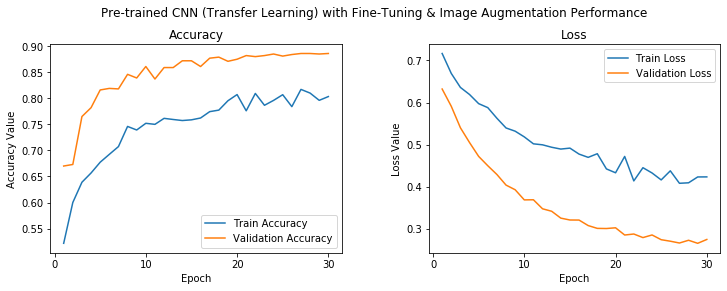

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')